# Introduction
Hi everyone! Welcome to my notebook on Titanic Spaceship Classification. To get started, let's take a look at the features in the dataset that we will be using as a guide/legend:

* PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
* HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
* CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
* Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* Destination - The planet the passenger will be debarking to.
* Age - The age of the passenger.
* VIP - Whether the passenger has paid for special VIP service during the voyage.
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
* Name - The first and last names of the passenger.
* Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

# Imports and Load Data

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import missingno as msno

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score, log_loss, hinge_loss

In [2]:
train = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
sample = pd.read_csv("/kaggle/input/spaceship-titanic/sample_submission.csv")

# Basic Exploration

In [3]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
train.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [6]:
print(train.shape)
print(test.shape)

(8693, 14)
(4277, 13)


# Data Preprocessing
Before we conduct our EDA, we want to clean up some of the data so that the visualization we get from the EDA makes more sense.

## 1. Missing Data

In [7]:
train.isnull().sum()[train.isnull().sum() > 0].sort_values(ascending=False) # Seeing how many missing values in each feature

CryoSleep       217
ShoppingMall    208
VIP             203
HomePlanet      201
Name            200
Cabin           199
VRDeck          188
FoodCourt       183
Spa             183
Destination     182
RoomService     181
Age             179
dtype: int64

In [8]:
test.isnull().sum()[test.isnull().sum() > 0].sort_values(ascending=False) # Seeing how many missing values in each feature

FoodCourt       106
Spa             101
Cabin           100
ShoppingMall     98
Name             94
CryoSleep        93
VIP              93
Destination      92
Age              91
HomePlanet       87
RoomService      82
VRDeck           80
dtype: int64

<Axes: >

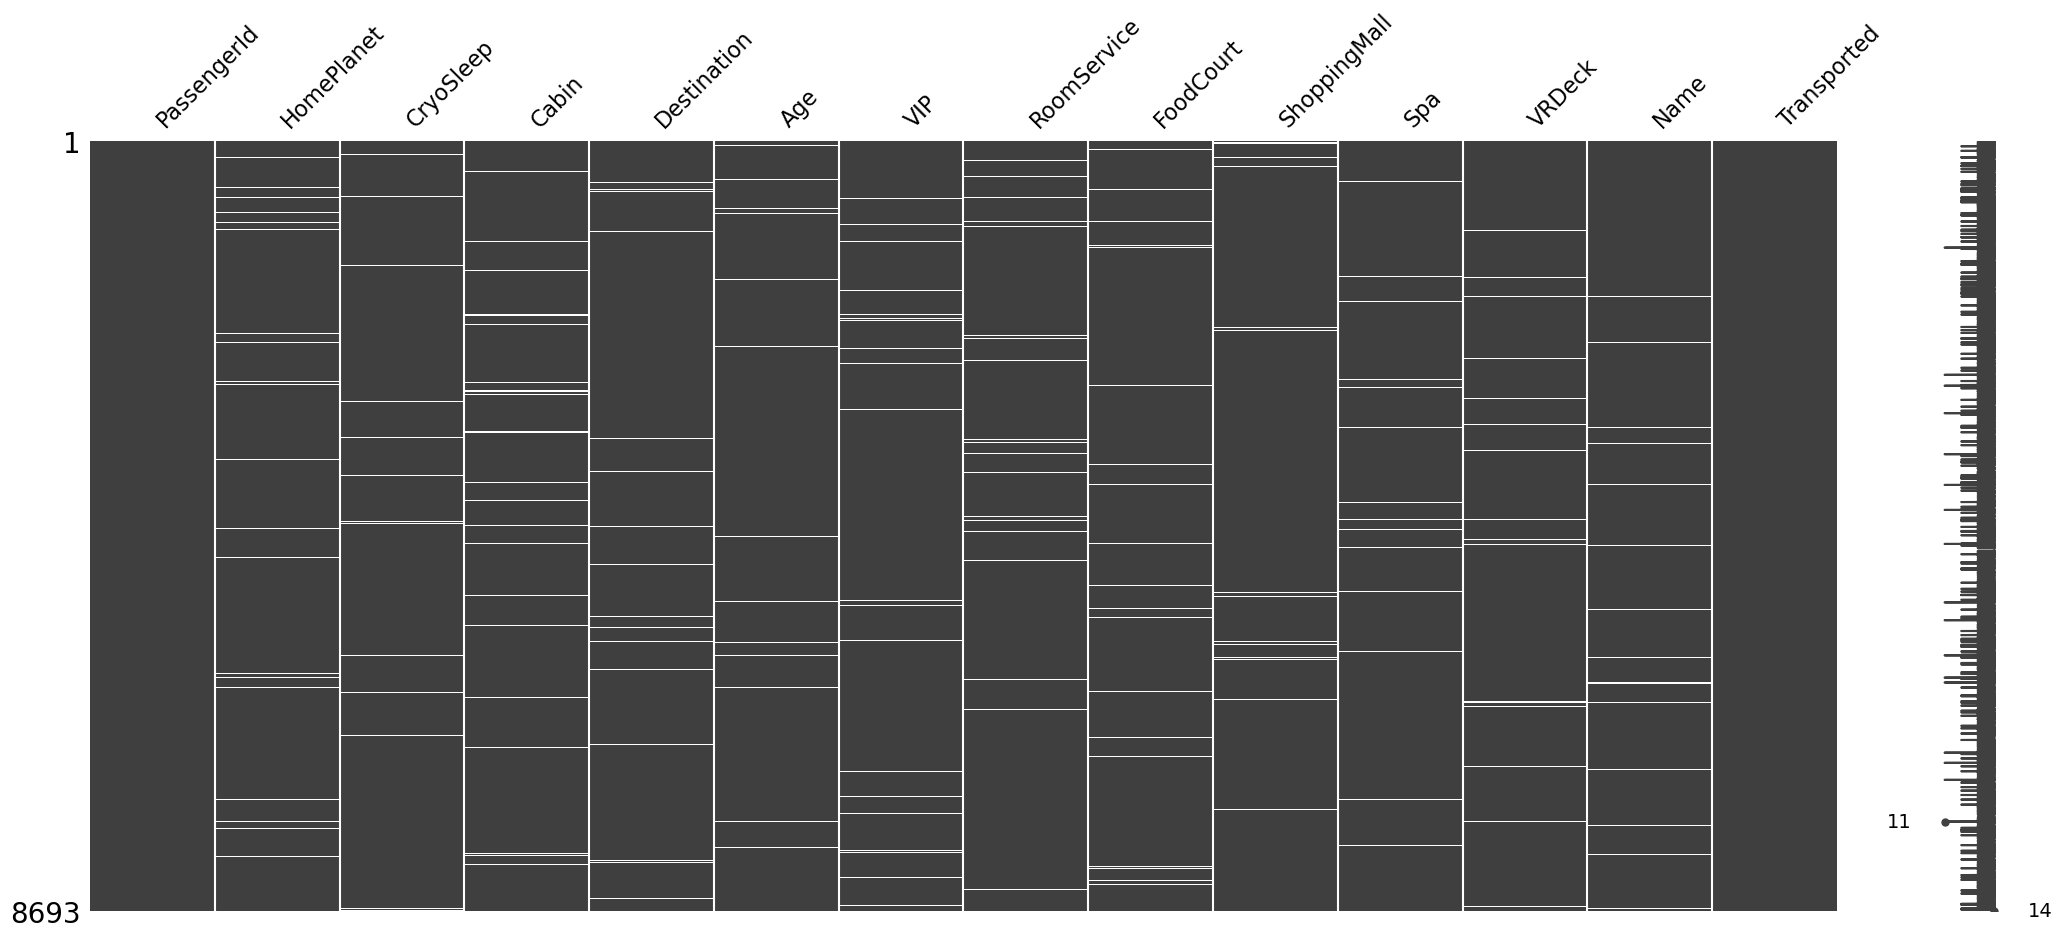

In [9]:
msno.matrix(train) # Visualizing the missing values

In [10]:
# Filling in missing values of categorical features with its mode
missing_feats = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin']

for feat in missing_feats:
    train[feat].fillna(train[feat].mode()[0], inplace = True)
    test[feat].fillna(test[feat].mode()[0], inplace = True)
    
# Filling in missing values of categorical features with its mode
missing_feats = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

for feat in missing_feats:
    train[feat].fillna(float(round(train[feat].mean())), inplace = True)
    test[feat].fillna(float(round(test[feat].mean())), inplace = True)

## 2. Separating Cabin features

In [11]:
# Initializing deck, num, and side lists
train_deck = []
train_num = []
train_side = []

test_deck = []
test_num = []
test_side = []

# Appending the lists based on the Cabin feature
for row in train['Cabin'].iteritems():
    train_deck.append(row[1].split('/')[0])
    train_num.append(row[1].split('/')[1])
    train_side.append(row[1].split('/')[2])
    
for row in test['Cabin'].iteritems():
    test_deck.append(row[1].split('/')[0])
    test_num.append(row[1].split('/')[1])
    test_side.append(row[1].split('/')[2])
    
# Creating the features from the lists
train['CabinDeck'] = train_deck
train['CabinNum'] = train_num
train['CabinSide'] = train_side

test['CabinDeck'] = test_deck
test['CabinNum'] = test_num
test['CabinSide'] = test_side

# Dropping the Cabin feature as it is no longer needed
train.drop('Cabin', axis=1, inplace=True)
test.drop('Cabin', axis=1, inplace=True)

## 3. Creating a TotalBill feature

In [12]:
# Creating a TotalBill feature that combines that amounts from all the other "bill" features
train['TotalBill'] = train['RoomService'] + train['FoodCourt'] + train['ShoppingMall'] + train['Spa'] + train['VRDeck']
test['TotalBill'] = test['RoomService'] + test['FoodCourt'] + test['ShoppingMall'] + test['Spa'] + test['VRDeck']

## 4. Converting Booleans into 0s and 1s

In [13]:
# Converting the boolean features (except for Transported) into 0s and 1s for better interpretibility in the model later
train["CryoSleep"] = train["CryoSleep"].astype(int)
train["VIP"] = train["VIP"].astype(int)

test["CryoSleep"] = test["CryoSleep"].astype(int)
test["VIP"] = test["VIP"].astype(int)

# Exploratory Data Analysis

In [14]:
# Categorical features
cat_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'CabinDeck', 'CabinNum', 'CabinSide']

# Numerical features
num_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalBill']

## Bivariate Analysis w.r.t Transported 

Text(0.5, 1.0, 'Transported Distribution')

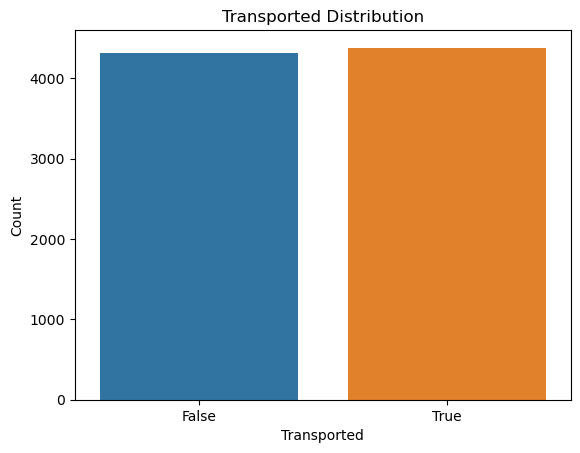

In [15]:
# Distribution of Transported
sns.countplot(train, x='Transported')
plt.xlabel("Transported")
plt.ylabel("Count")
plt.title("Transported Distribution")

Observations:
* It is quite evenly distributed

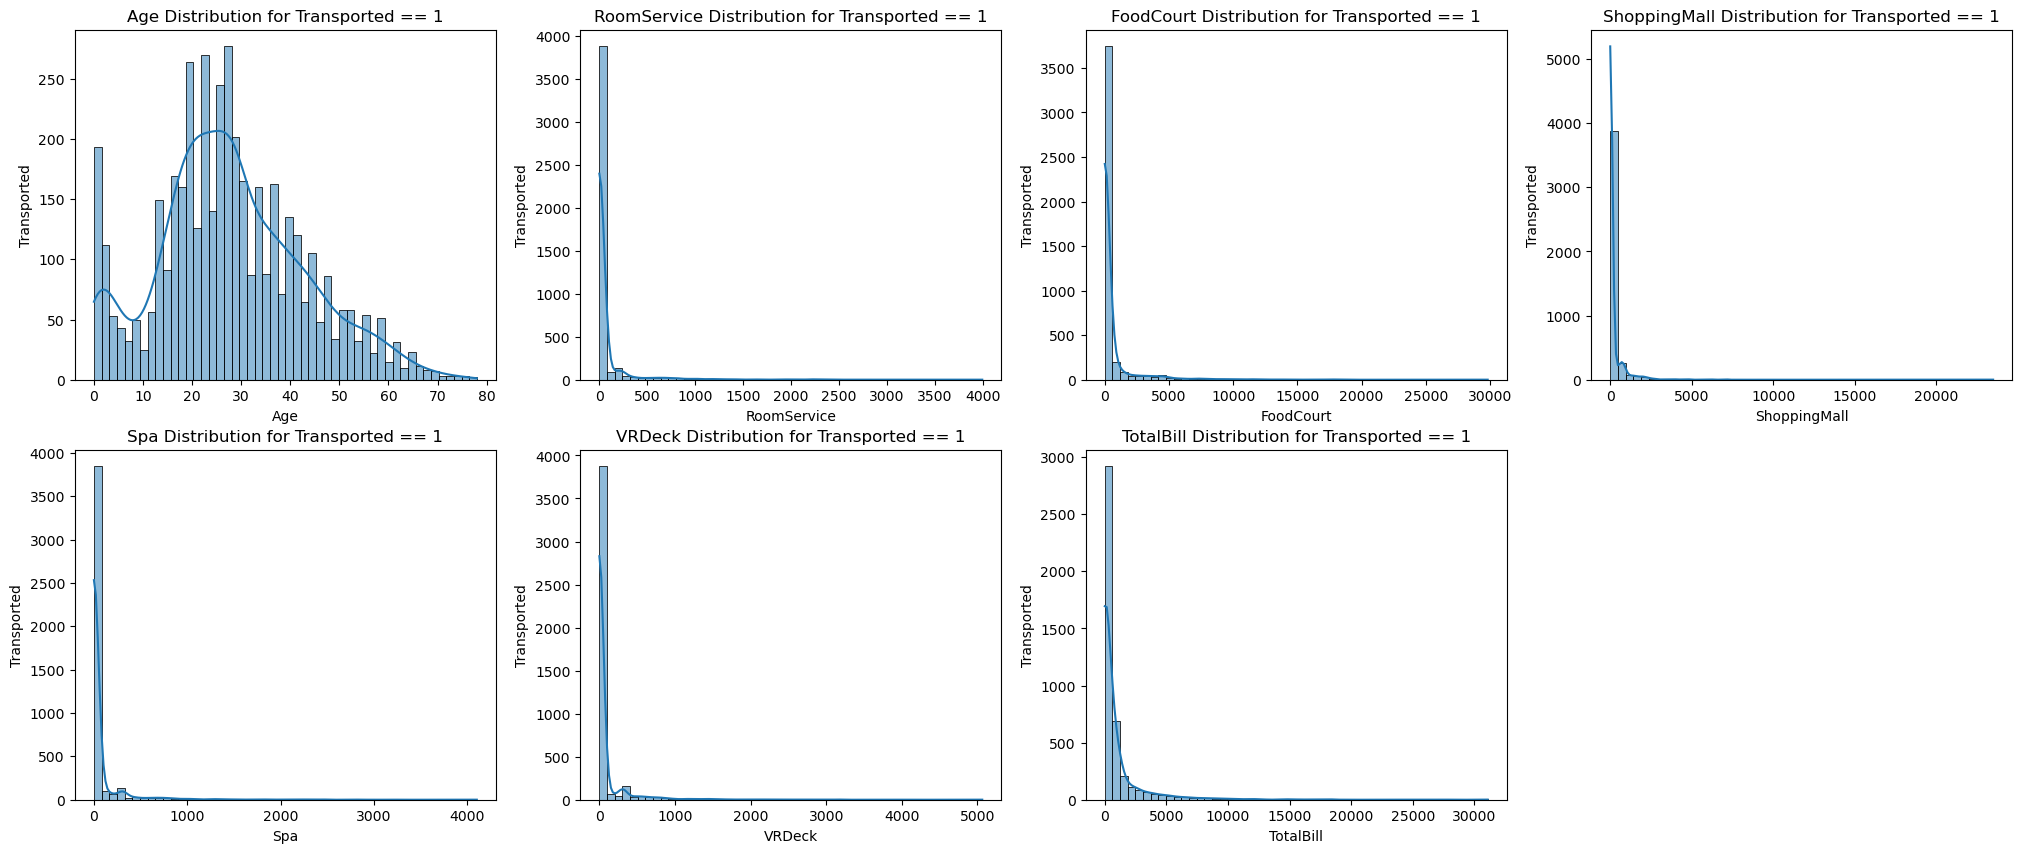

In [16]:
plt.figure(figsize=(25,10))
for index,column in enumerate(num_features):
    plt.subplot(2,4,index+1)
    sns.histplot(train[train['Transported'] == 1], x=column, bins=50, kde=True)
    plt.xlabel(column)
    plt.ylabel('Transported')
    plt.title(f"{column} Distribution for Transported == 1")

Observations:
* We can see that aside from Age, every other feature is heavily skewed to the right. In fact, a lot of them are centred right at the 0 marker. We will repeat this visualization with the exlusion of 0 as a value.
* Age shows that the average passenger age that were transported are in their late 20s as well as babies at the 0 age.
* Also, we will be dropping all the features aside from Age and TotalBill as they just make up TotalBill.

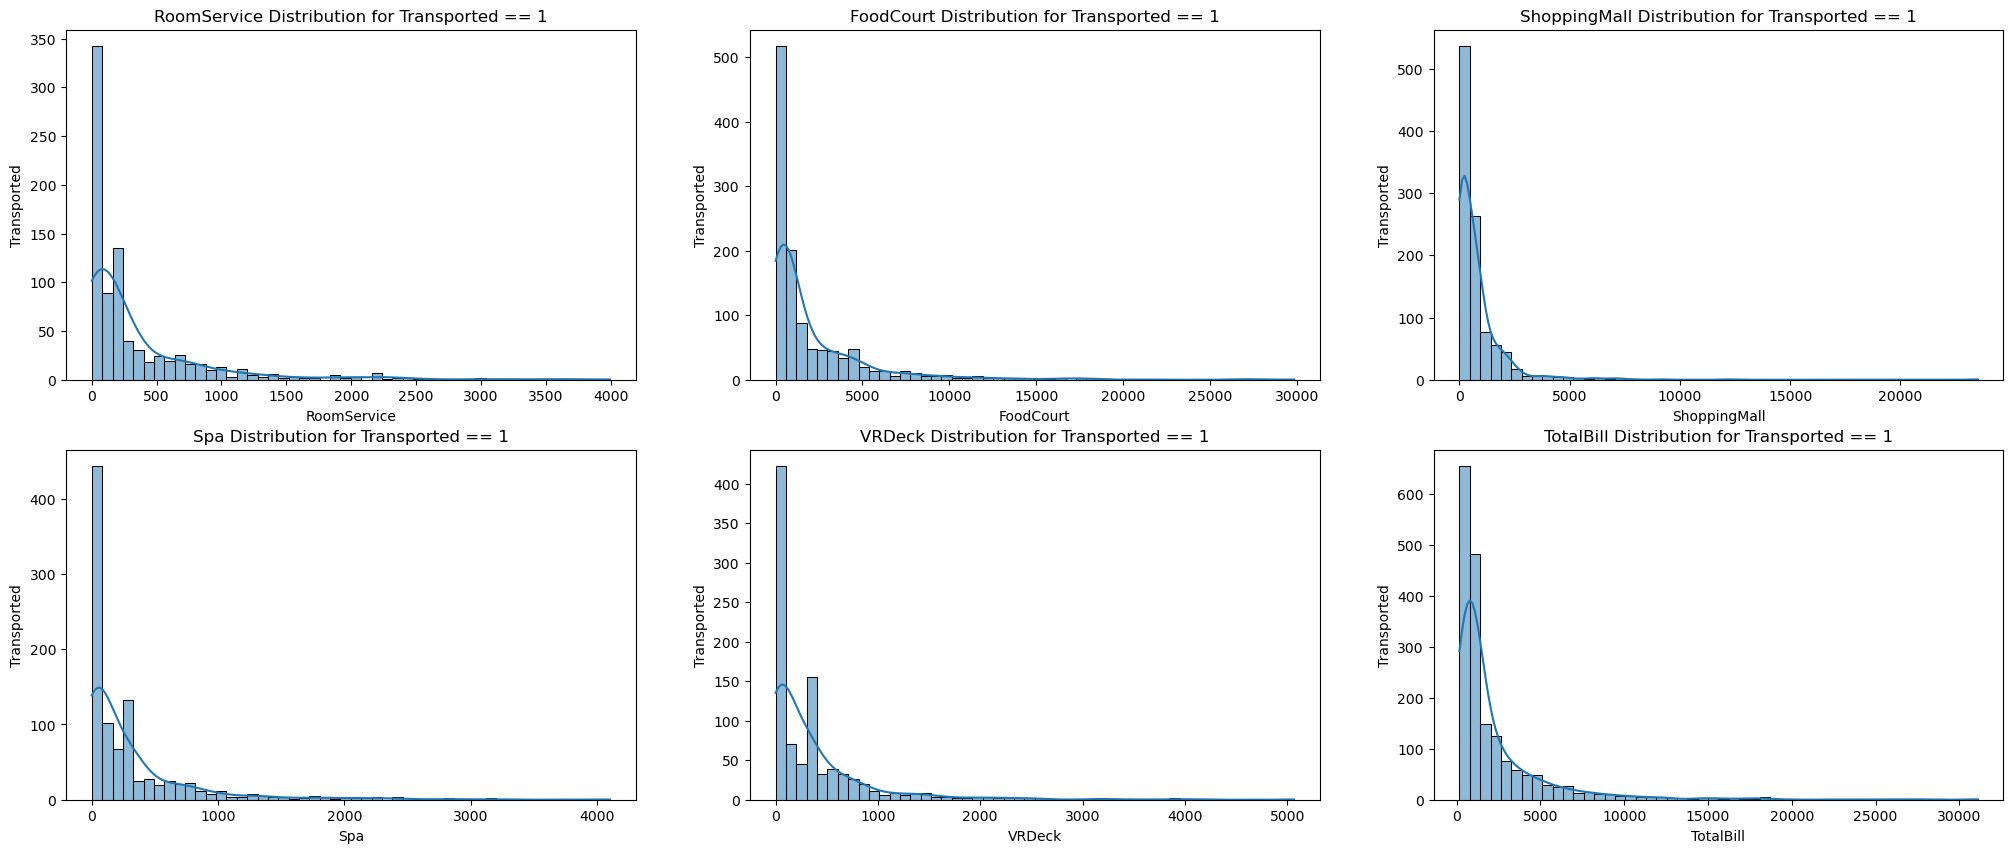

In [17]:
plt.figure(figsize=(25,10))
for index,column in enumerate(num_features[1:]):
    plt.subplot(2,3,index+1)
    sns.histplot(train[(train['Transported'] == 1) & (train[column] != 0)], x=column, bins=50, kde=True)
    plt.xlabel(column)
    plt.ylabel('Transported')
    plt.title(f"{column} Distribution for Transported == 1")

Observations:
* As we can see, the max count for these features dropped significantly from ~3k or ~4k to only around 600 max in TotalBill. This shows that most people in the spaceship did not even spend any money. This may be explained if they were in CryoSleep or the fact that they are not rich. 

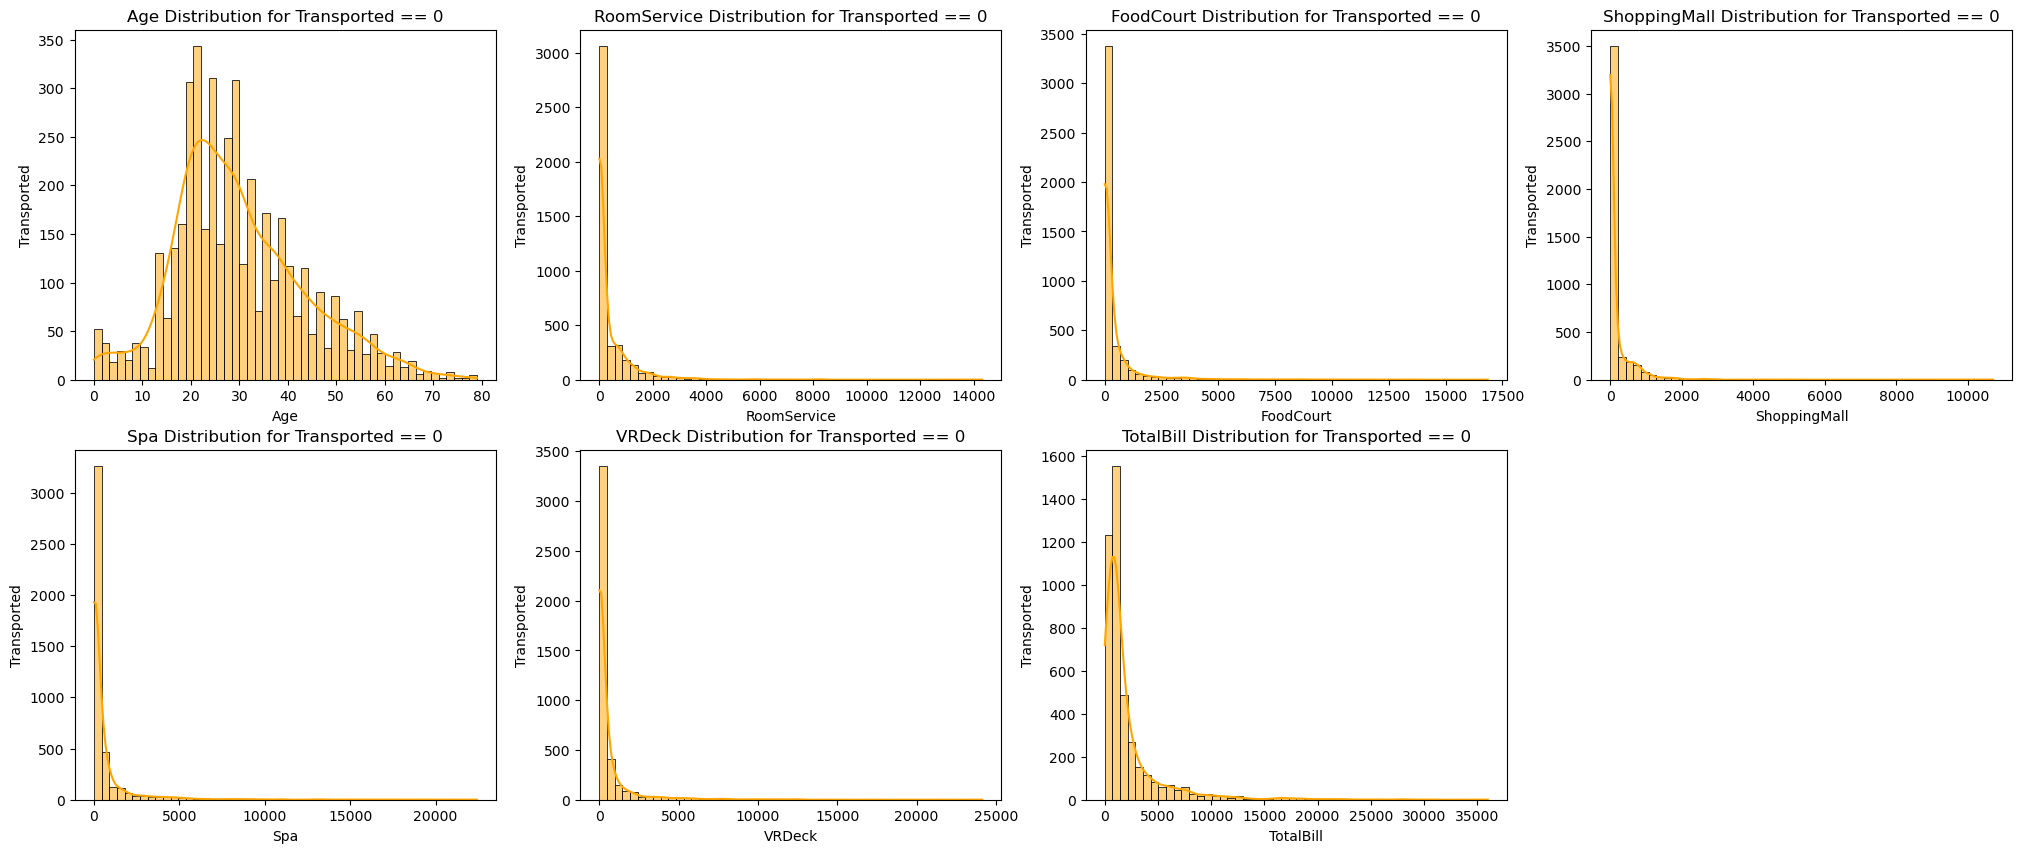

In [18]:
plt.figure(figsize=(25,10))
for index,column in enumerate(num_features):
    plt.subplot(2,4,index+1)
    sns.histplot(train[train['Transported'] == 0], x=column, bins=50, kde=True, color="Orange")
    plt.xlabel(column)
    plt.ylabel('Transported')
    plt.title(f"{column} Distribution for Transported == 0")

Observations:
* Similar to those who were transported, we can see that every feature other than Age are heavily skewed to the right. Again, we will repeat this visualization with the exclusion of 0 as a value.
* Unlike those who were transported, the average age of those who weren't transported are in their early 20s.

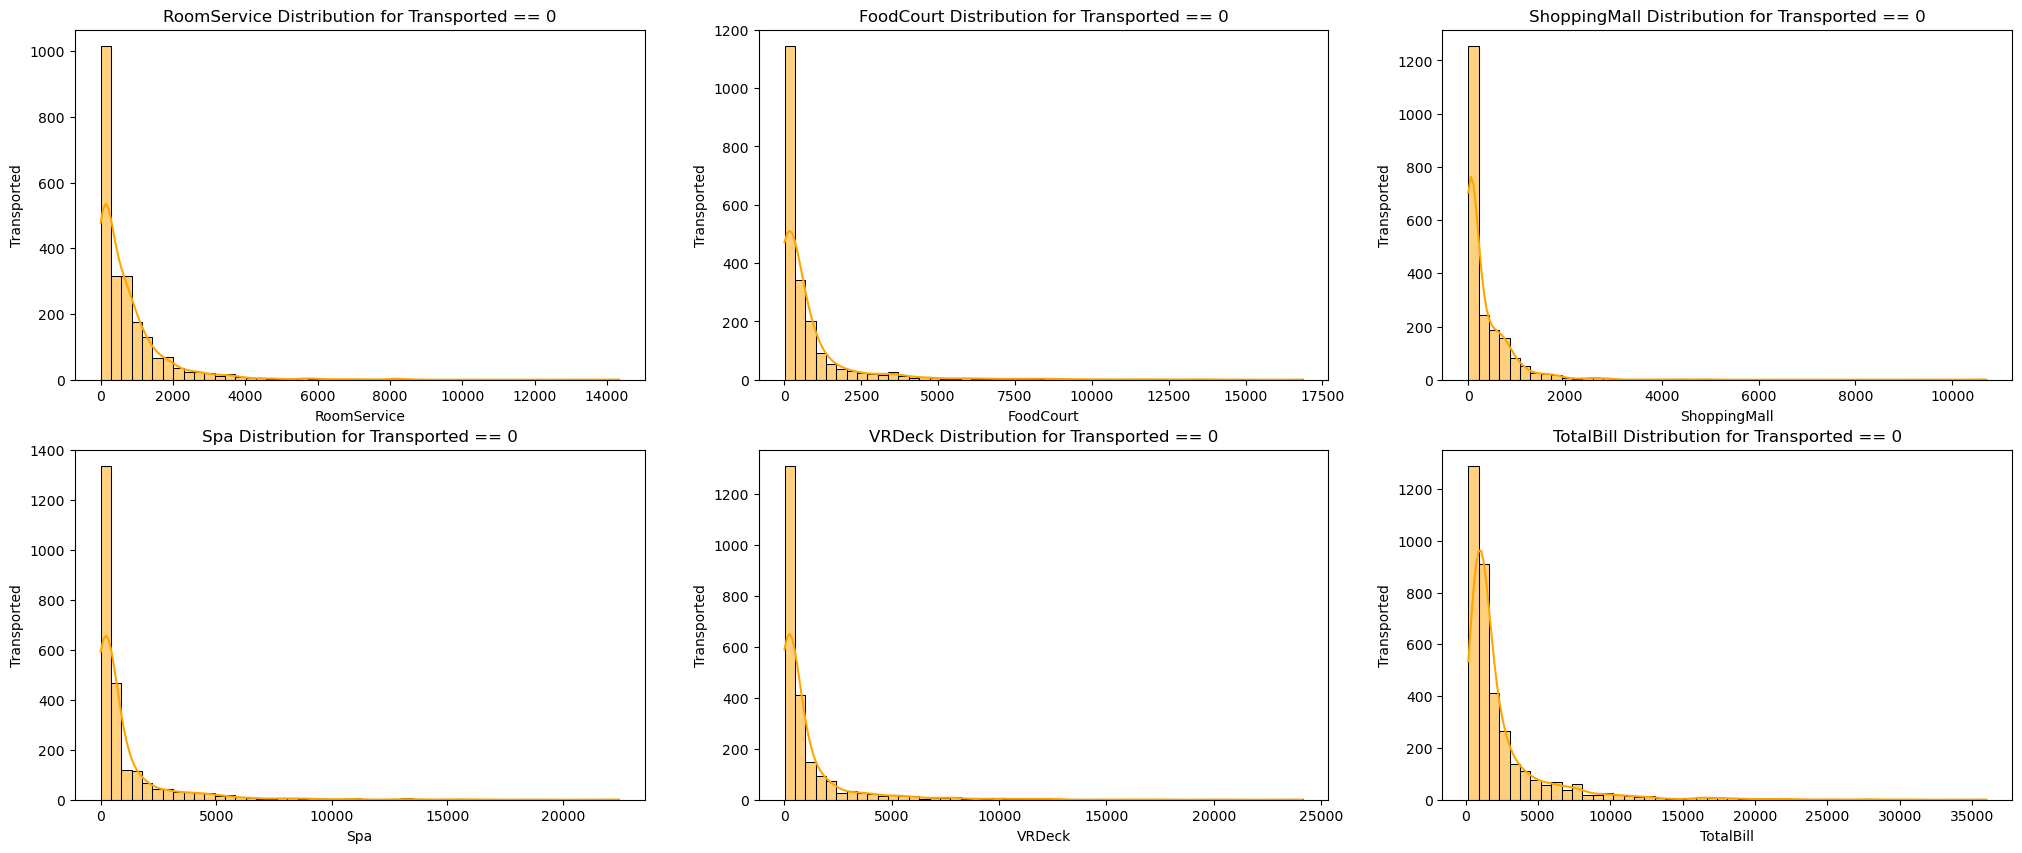

In [19]:
plt.figure(figsize=(25,10))
for index,column in enumerate(num_features[1:]):
    plt.subplot(2,3,index+1)
    sns.histplot(train[(train['Transported'] == 0) & (train[column] != 0)], x=column, bins=50, kde=True, color="Orange")
    plt.xlabel(column)
    plt.ylabel('Transported')
    plt.title(f"{column} Distribution for Transported == 0")

Observations:
* This is interesting as we can see that the max count in Total Bill is around 1200, higher than the 600 for those who were transported. This may suggest that those who are richer are less likely to be transported.

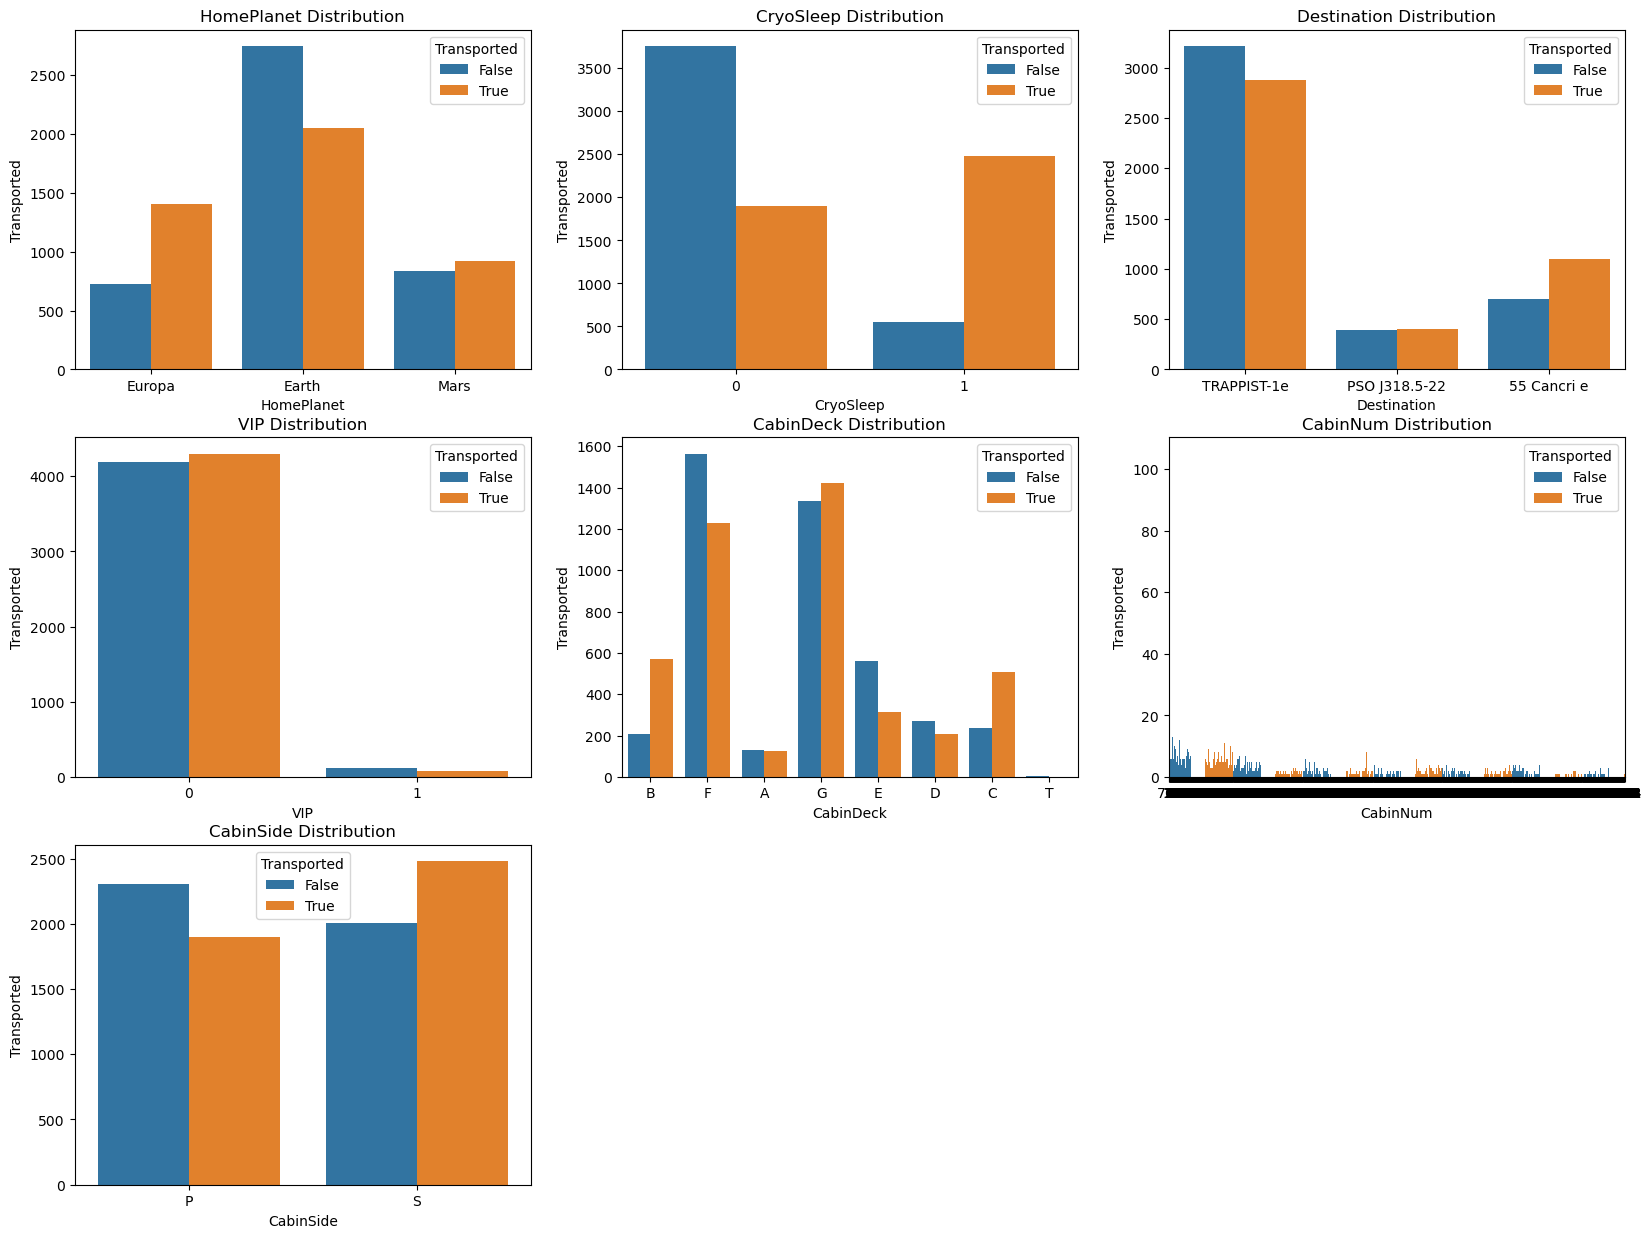

In [20]:
plt.figure(figsize=(20,15))
for index,column in enumerate(cat_features):
    plt.subplot(3,3,index+1)
    sns.countplot(train, x=column, hue='Transported')
    plt.xlabel(column)
    plt.ylabel('Transported')
    plt.title(f"{column} Distribution")

Observations:
* CabinNum has too large of a cardinality. We will drop this feature.
* VIP seems to have too much of an even distribution for both 0 and 1 which means that it might not be a good predictor for Transported. We will drop this feature.
* We can see that the other categorical features are distributed quite nicely.

# Feature Engineering
## Dropping features


In [21]:
# Dropping CabinNum and VIP as indicated previously
train.drop(['CabinNum', 'VIP', 'TotalBill'], axis=1, inplace=True)
test.drop(['CabinNum', 'VIP', 'TotalBill'], axis=1, inplace=True)

## One-Hot Encoding (Dummy Variables)

In [22]:
# Creating dummy variables for the categorical features
train = pd.get_dummies(train, columns=['HomePlanet', 'Destination', 'CabinDeck', 'CabinSide'], drop_first=True)
test = pd.get_dummies(test, columns=['HomePlanet', 'Destination', 'CabinDeck', 'CabinSide'], drop_first=True)

# Model Selection

In [23]:
# Metrics
accuracy = []
balanced_accuracy = []
precision = []
recall = []
f1 = []
log_loss_value = []
hinge_loss_value = []

# Function that operates the model specified can calculating the metrics based on the respective models
def model_result(model):
    
    # Specifying X and y
    X = train.drop(['Name', 'PassengerId','Transported'], axis=1)
    y = train['Transported']

    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    # Fitting the model and getting the predictions
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    # Appending the metrics list
    accuracy.append(round(accuracy_score(y_test,pred),4))
    balanced_accuracy.append(round(balanced_accuracy_score(y_test,pred),4))
    precision.append(round(precision_score(y_test,pred),4))
    recall.append(round(recall_score(y_test,pred),4))
    f1.append(round(f1_score(y_test,pred),4))
    log_loss_value.append(round(log_loss(y_test,pred),4))
    hinge_loss_value.append(round(hinge_loss(y_test,pred),4))

    # Printing the confusion matrix and classification report
    print("Confusion matrix: \n")
    print(confusion_matrix(y_test, pred))
    print('\n')
    print("Classification report: \n")
    print(classification_report(y_test, pred))

## Logistic Regression

In [24]:
model_result(LogisticRegression())

Confusion matrix: 

[[1055  369]
 [ 272 1173]]


Classification report: 

              precision    recall  f1-score   support

       False       0.80      0.74      0.77      1424
        True       0.76      0.81      0.79      1445

    accuracy                           0.78      2869
   macro avg       0.78      0.78      0.78      2869
weighted avg       0.78      0.78      0.78      2869



## Decision Tree

In [25]:
model_result(DecisionTreeClassifier())

Confusion matrix: 

[[1037  387]
 [ 379 1066]]


Classification report: 

              precision    recall  f1-score   support

       False       0.73      0.73      0.73      1424
        True       0.73      0.74      0.74      1445

    accuracy                           0.73      2869
   macro avg       0.73      0.73      0.73      2869
weighted avg       0.73      0.73      0.73      2869



## Gaussian Naive Bayes

In [26]:
model_result(GaussianNB())

Confusion matrix: 

[[ 807  617]
 [ 135 1310]]


Classification report: 

              precision    recall  f1-score   support

       False       0.86      0.57      0.68      1424
        True       0.68      0.91      0.78      1445

    accuracy                           0.74      2869
   macro avg       0.77      0.74      0.73      2869
weighted avg       0.77      0.74      0.73      2869



## Support Vector Classifier

In [27]:
model_result(SVC())

Confusion matrix: 

[[ 946  478]
 [ 166 1279]]


Classification report: 

              precision    recall  f1-score   support

       False       0.85      0.66      0.75      1424
        True       0.73      0.89      0.80      1445

    accuracy                           0.78      2869
   macro avg       0.79      0.77      0.77      2869
weighted avg       0.79      0.78      0.77      2869



## K-Neighbors

In [28]:
model_result(KNeighborsClassifier())

Confusion matrix: 

[[1064  360]
 [ 300 1145]]


Classification report: 

              precision    recall  f1-score   support

       False       0.78      0.75      0.76      1424
        True       0.76      0.79      0.78      1445

    accuracy                           0.77      2869
   macro avg       0.77      0.77      0.77      2869
weighted avg       0.77      0.77      0.77      2869



## Model Evaluation
The table below summarizes the metrics of the different models

In [29]:
metrics = pd.DataFrame(list(zip(accuracy, balanced_accuracy, precision, recall, f1, log_loss_value, hinge_loss_value)),
                       columns=['Accuracy','Balanced accuracy', 'Precision', 'Recall', 'F1 score', 'Log loss', 'Hinge loss'])
metrics.index = ["Logistic Regression", "Decision Tree", "Gaussian Naive Bayes", "Support Vector Classifier", "k-Nearest Neighbors"]
metrics

,Accuracy,Balanced accuracy,Precision,Recall,F1 score,Log loss,Hinge loss
Logistic Regression,0.7766,0.7763,0.7607,0.8118,0.7854,8.0530,0.7198
Decision Tree,0.7330,0.7330,0.7337,0.7377,0.7357,9.6234,0.7633
Gaussian Naive Bayes,0.7379,0.7366,0.6798,0.9066,0.7770,9.4475,0.7585
Support Vector Classifier,0.7755,0.7747,0.7279,0.8851,0.7989,8.0907,0.7208
k-Nearest Neighbors,0.7700,0.7698,0.7608,0.7924,0.7763,8.2917,0.7264


As we can see, the two best models in terms of accuracy, f1-score, and minimal loss values are the Logistic Regression Model and Support Vector Classifier. Upon further inspection, it can be seen that Logistic Regression beats out SVC by a near margin. Because of this, we will be using Logistic Regression for the test set.

# Hyperparameter Tuning for Logistic Regression
Since we have chosen Logistic Regression to be our model, let's conduct some hyperparameter tuning to see if we can further improve the model.

In [30]:
# Resetting the metrics
accuracy = []
balanced_accuracy = []
precision = []
recall = []
f1 = []
log_loss_value = []
hinge_loss_value = []

# Running logistic regression models with different penalties
model_result(LogisticRegression(penalty='l2'))
model_result(LogisticRegression(C=1, penalty='l1', solver='liblinear'))
model_result(LogisticRegression(C=1, penalty='elasticnet', solver='saga', l1_ratio=0.5))

# Running SVC models
model_result(SVC(kernel='rbf'))
model_result(SVC(kernel='poly'))
model_result(SVC(kernel='sigmoid'))

Confusion matrix: 

[[1055  369]
 [ 272 1173]]


Classification report: 

              precision    recall  f1-score   support

       False       0.80      0.74      0.77      1424
        True       0.76      0.81      0.79      1445

    accuracy                           0.78      2869
   macro avg       0.78      0.78      0.78      2869
weighted avg       0.78      0.78      0.78      2869

Confusion matrix: 

[[1053  371]
 [ 251 1194]]


Classification report: 

              precision    recall  f1-score   support

       False       0.81      0.74      0.77      1424
        True       0.76      0.83      0.79      1445

    accuracy                           0.78      2869
   macro avg       0.79      0.78      0.78      2869
weighted avg       0.79      0.78      0.78      2869

Confusion matrix: 

[[ 978  446]
 [ 229 1216]]


Classification report: 

              precision    recall  f1-score   support

       False       0.81      0.69      0.74      1424
        True   

In [31]:
metrics = pd.DataFrame(list(zip(accuracy, balanced_accuracy, precision, recall, f1, log_loss_value, hinge_loss_value)),
                       columns=['Accuracy','Balanced accuracy', 'Precision', 'Recall', 'F1 score', 'Log loss', 'Hinge loss'])
metrics.index = ["Logistic Regression (L2)", "Logistic Regression (L1)", "Logistic Regression (Elastic Net with alpha=0.5)",
                 "SVC (kernel=rbf)", "SVC (kernel=poly)", "SVC (kernel=sigmoid)"]
metrics

,Accuracy,Balanced accuracy,Precision,Recall,F1 score,Log loss,Hinge loss
Logistic Regression (L2),0.7766,0.7763,0.7607,0.8118,0.7854,8.0530,0.7198
Logistic Regression (L1),0.7832,0.7829,0.7629,0.8263,0.7934,7.8143,0.7131
Logistic Regression (Elastic Net with alpha=0.5),0.7647,0.7642,0.7316,0.8415,0.7827,8.4801,0.7316
SVC (kernel=rbf),0.7755,0.7747,0.7279,0.8851,0.7989,8.0907,0.7208
SVC (kernel=poly),0.6187,0.6160,0.5703,0.9848,0.7223,13.7441,0.8777
SVC (kernel=sigmoid),0.7142,0.7139,0.7007,0.7550,0.7268,10.3018,0.7822


As we can see, Logistic Regression with L1 penalty seems to yield the best result in terms of accuracy, f1 score and log loss compared to the other models. Therefore, we will be using this model for the test set.

# Applying to Test

In [32]:
# Specifying X and y
X_train = train.drop(['Name', 'PassengerId','Transported'], axis=1)
y_train = train['Transported']

X_test = test.drop(['Name', 'PassengerId'], axis=1)

# Fitting the model
model =LogisticRegression(C=1, penalty='l1', solver='liblinear')
model.fit(X_train, y_train)

# Getting the predictions
pred = model.predict(X_test)

# Creating the submission dataframe
submission = pd.DataFrame(columns=['PassengerId', 'Transported'])
submission['PassengerId'] = test['PassengerId']
submission['Transported'] = pred

# Converting into csv
submission.to_csv('submission.csv',index=False)